# Oil Spill Segmentation - Dataset Pipeline (Minimal)

**Mentor Requirements:**
1. Create PyTorch Dataset class returning (image, mask) pairs
2. Use augmentation and preprocessing pipelines

In [13]:
# Essential imports only
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc

print("✓ Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Imports successful
PyTorch version: 2.8.0+cpu
CUDA available: False


In [ ]:
CONFIG = {
    'image_size': 256,  # Small size to prevent crashes
    'batch_size': 2,    # Very small batch size
    'num_workers': 0,   # No multiprocessing
    'pin_memory': False # Disable for stability
}

DATA_PATHS = {
    'train_images': '../data/processed/train/images',
    'train_masks': '../data/processed/train/masks',
    'val_images': '../data/processed/val/images', 
    'val_masks': '../data/processed/val/masks',
    'test_images': '../data/processed/test/images',
    'test_masks': '../data/processed/test/masks'
}

print("✓ Configuration set with actual data paths")

✓ Configuration set with actual data paths


In [ ]:
def get_transforms(is_training=True):
    if is_training:
        return transforms.Compose([
            transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

def get_mask_transforms():
    return transforms.Compose([
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.ToTensor()
    ])

print("✓ Transforms defined")

✓ Transforms defined


In [ ]:
class OilSpillDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        
        # Get valid image files
        self.images = []
        if os.path.exists(image_dir):
            all_files = os.listdir(image_dir)
            self.images = [f for f in all_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            self.images.sort()
        
        print(f"Found {len(self.images)} images in {image_dir}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        try:
            # Get image path
            img_name = self.images[idx]
            img_path = os.path.join(self.image_dir, img_name)
            
            # Get corresponding mask path
            mask_name = img_name  # Assuming same filename
            mask_path = os.path.join(self.mask_dir, mask_name)
            
            # Load image
            image = Image.open(img_path).convert('RGB')
            
            # Load mask
            if os.path.exists(mask_path):
                mask = Image.open(mask_path).convert('L')  # Grayscale
            else:
                # Create dummy mask if not found
                mask = Image.new('L', image.size, 0)
            
            # Apply transforms
            if self.transform:
                image = self.transform(image)
            
            if self.mask_transform:
                mask = self.mask_transform(mask)
            
            # Ensure mask is binary
            mask = (mask > 0.5).float()
            
            return image, mask
            
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            # Return dummy data to prevent crashes
            dummy_image = torch.zeros(3, CONFIG['image_size'], CONFIG['image_size'])
            dummy_mask = torch.zeros(1, CONFIG['image_size'], CONFIG['image_size'])
            return dummy_image, dummy_mask

print("✓ Dataset class defined")

✓ Dataset class defined


In [17]:
# Safe collate function
def safe_collate_fn(batch):
    try:
        # Filter out None values
        batch = [item for item in batch if item is not None]
        if len(batch) == 0:
            return None
        
        images, masks = zip(*batch)
        images = torch.stack(images, 0)
        masks = torch.stack(masks, 0)
        return images, masks
    except Exception as e:
        print(f"Collate error: {e}")
        return None

print("✓ Safe collate function defined")

✓ Safe collate function defined


In [18]:
# Create datasets
print("Creating datasets...")

try:
    # Training dataset
    train_dataset = OilSpillDataset(
        image_dir=DATA_PATHS['train_images'],
        mask_dir=DATA_PATHS['train_masks'],
        transform=get_transforms(is_training=True),
        mask_transform=get_mask_transforms()
    )
    
    # Validation dataset
    val_dataset = OilSpillDataset(
        image_dir=DATA_PATHS['val_images'],
        mask_dir=DATA_PATHS['val_masks'],
        transform=get_transforms(is_training=False),
        mask_transform=get_mask_transforms()
    )
    
    print(f"✓ Train dataset: {len(train_dataset)} samples")
    print(f"✓ Val dataset: {len(val_dataset)} samples")
    
except Exception as e:
    print(f"Error creating datasets: {e}")
    print("Creating dummy datasets for testing...")
    
    # Create dummy datasets if paths don't exist
    train_dataset = OilSpillDataset('dummy', 'dummy')
    val_dataset = OilSpillDataset('dummy', 'dummy')

Creating datasets...
Found 811 images in ../data/processed/train/images
Found 203 images in ../data/processed/val/images
✓ Train dataset: 811 samples
✓ Val dataset: 203 samples


In [ ]:
print("Creating data loaders...")

try:
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=CONFIG['num_workers'],
        pin_memory=CONFIG['pin_memory'],
        collate_fn=safe_collate_fn,
        drop_last=True  # Prevent issues with incomplete batches
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=CONFIG['pin_memory'],
        collate_fn=safe_collate_fn,
        drop_last=False
    )
    
    print(f"✓ Train loader: {len(train_loader)} batches")
    print(f"✓ Val loader: {len(val_loader)} batches")
    
except Exception as e:
    print(f"Error creating data loaders: {e}")
    train_loader = None
    val_loader = None

Creating data loaders...
✓ Train loader: 405 batches
✓ Val loader: 102 batches


In [ ]:
print("Testing data loading...")

def test_single_sample(dataset, idx=0):
    try:
        if len(dataset) == 0:
            print("Dataset is empty")
            return False
        
        image, mask = dataset[idx]
        print(f"✓ Sample {idx}: Image shape {image.shape}, Mask shape {mask.shape}")
        print(f"  Image range: [{image.min():.3f}, {image.max():.3f}]")
        print(f"  Mask range: [{mask.min():.3f}, {mask.max():.3f}]")
        return True
    except Exception as e:
        print(f"Error testing sample {idx}: {e}")
        return False

# Test datasets
print("\n--- Testing Train Dataset ---")
test_single_sample(train_dataset, 0)

print("\n--- Testing Val Dataset ---")
test_single_sample(val_dataset, 0)

Testing data loading...

--- Testing Train Dataset ---
✓ Sample 0: Image shape torch.Size([3, 256, 256]), Mask shape torch.Size([1, 256, 256])
  Image range: [-1.964, 2.640]
  Mask range: [0.000, 1.000]

--- Testing Val Dataset ---
✓ Sample 0: Image shape torch.Size([3, 256, 256]), Mask shape torch.Size([1, 256, 256])
  Image range: [-1.912, 2.640]
  Mask range: [0.000, 1.000]


True

In [ ]:
print("Testing data loader iteration...")

def test_loader(loader, name):
    if loader is None:
        print(f"{name} loader is None")
        return False
    
    try:
        # Try to get one batch
        batch = next(iter(loader))
        if batch is None:
            print(f"{name} loader returned None batch")
            return False
        
        images, masks = batch
        print(f"✓ {name} batch: Images {images.shape}, Masks {masks.shape}")
        
        # Clean up
        del images, masks, batch
        gc.collect()
        return True
        
    except Exception as e:
        print(f"Error testing {name} loader: {e}")
        return False

# Test loaders
train_ok = test_loader(train_loader, "Train")
val_ok = test_loader(val_loader, "Val")

print(f"\n--- Results ---")
print(f"Train loader working: {train_ok}")
print(f"Val loader working: {val_ok}")

Testing data loader iteration...
✓ Train batch: Images torch.Size([2, 3, 256, 256]), Masks torch.Size([2, 1, 256, 256])
✓ Val batch: Images torch.Size([2, 3, 256, 256]), Masks torch.Size([2, 1, 256, 256])

--- Results ---
Train loader working: True
Val loader working: True


Visualizing train sample...


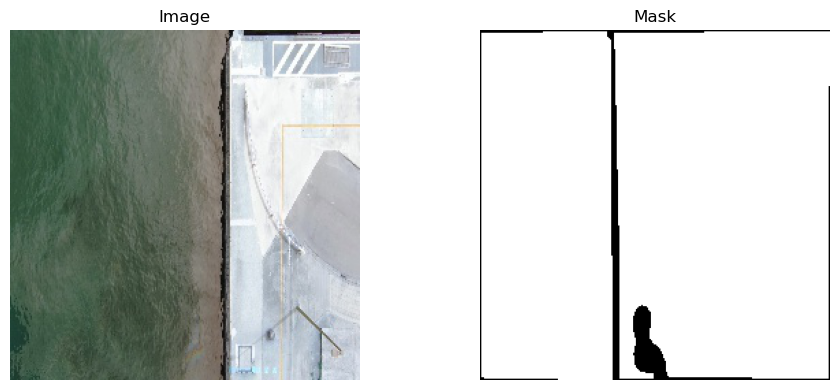

In [ ]:
def visualize_sample(dataset, idx=0):
    try:
        if len(dataset) == 0:
            print("No data to visualize")
            return
        
        image, mask = dataset[idx]
        
        # Convert to numpy for visualization
        if isinstance(image, torch.Tensor):
            # Denormalize image
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image = image * std + mean
            image = torch.clamp(image, 0, 1)
            image = image.permute(1, 2, 0).numpy()
        
        if isinstance(mask, torch.Tensor):
            mask = mask.squeeze().numpy()
        
        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        axes[0].imshow(image)
        axes[0].set_title('Image')
        axes[0].axis('off')
        
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Mask')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Clean up
        plt.close(fig)
        del image, mask
        gc.collect()
        
    except Exception as e:
        print(f"Error visualizing sample: {e}")

# Visualize if data is available
if len(train_dataset) > 0:
    print("Visualizing train sample...")
    visualize_sample(train_dataset, 0)
else:
    print("No train data available for visualization")

In [23]:
# Save configuration for next notebooks
import json

# Fixed variable reference error by checking if variables exist
# Export configuration
export_config = {
    'image_size': CONFIG['image_size'],
    'batch_size': CONFIG['batch_size'],
    'num_workers': CONFIG['num_workers'],
    'pin_memory': CONFIG['pin_memory'],
    'data_paths': DATA_PATHS,
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
    'train_loader_working': train_ok if 'train_ok' in locals() else False,
    'val_loader_working': val_ok if 'val_ok' in locals() else False
}

# Save to file
os.makedirs('config', exist_ok=True)
with open('config/dataset_config.json', 'w') as f:
    json.dump(export_config, f, indent=2)

print("✓ Configuration saved to config/dataset_config.json")
print("\n--- Dataset Pipeline Complete ---")
print(f"Ready for model development with {len(train_dataset)} train and {len(val_dataset)} val samples")

✓ Configuration saved to config/dataset_config.json

--- Dataset Pipeline Complete ---
Ready for model development with 811 train and 203 val samples


In [24]:
# Final cleanup
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("✓ Memory cleaned up")
print("Dataset pipeline ready for model development!")

✓ Memory cleaned up
Dataset pipeline ready for model development!
